In [1]:
import glob
# from slab import *
#import PyInventor
#from PyInventor import *
%load_ext autoreload
%autoreload 2
#import pyEPR as epr
#from pyEPR import ansys as HFSS
import numpy as np

%matplotlib notebook

import pandas as pd
import pyEPR
from pyEPR import ansys as HFSS

import scipy
from scipy import constants as const

from pint import UnitRegistry
ureg = UnitRegistry()
Q = ureg.Quantity
import os
import matplotlib.pyplot as plt

def flt2strfmt(val, fmt='%.3f', units='mm'):
    return (fmt % val) + units

import matplotlib
import datetime

# Add junction and chip

In [2]:
'''
HFSS eigenmode simulation Creation:

This sets up a standard eigenmode simulation without the qubit, just the bare cavity created above. It calculates
the mode frequencies, loss (with boundary impedances set) and the electric and magnetic surface participation 
ratios (S_e, S_m)

'''
# Define the number of LC sections in the transmission
# line model of the cavity
NLC = 100
jj_idx = 10


# Define the cavity parameters [mm]
z_cav_1 = 55
y_cav_1 = 25
x_cav_1 = 5
z_cav_2 = 55
y_cav_2 = 25
x_cav_2 = 5
z_offset = 3
cav_thickness = 1

# Define the coupler parameters [mmm]
z_coupler = 100.
y_coupler = 25.
x_coupler = 10.
coupler_offset = 0.

lamb0 = z_coupler / 2
jj_z_offset = jj_idx * lamb0 / (2*NLC)

# Light and heavy modes (500, 100 um)
# l_junc = 500e-3
# l_junc = 100e-3
l_junc = 0.05
coupler_pads = (x_coupler - l_junc) / 2
y_pads = 0.1
w_junc = l_junc / 2 * 1e-3

# Project and HFSS design names for the bare waveguide model
dd = datetime.datetime.today().strftime('%y%m%d')
ref_name = 'monolithic_pads_l_coupled_bbq_y11'
project_name=f'{ref_name}_{dd}'
design_name=f'{ref_name}_hfss_design_{dd}'
overwrite=True

#use file location path:
HFSS_path=os.getcwd()

full_path=HFSS_path+'\\HFSS\\'+project_name+'.aedt'

HFSS_app=HFSS.HfssApp()
HFSS_desktop=HFSS_app.get_app_desktop()

project=HFSS_desktop.open_project(full_path)

if project==None:
    project=HFSS_desktop.new_project()
    project.save(full_path)
    
project.save(full_path)
project.make_active()
    
if design_name in project.get_design_names():
    if overwrite==True:
        project.delete_design(design_name)
        project.save()
        EM_design=project.new_em_design(design_name)
    else:
        EM_design=project.get_design(design_name)
        
else:
    EM_design=project.new_em_design(design_name)
        
EM_design.make_active()
model=HFSS.HfssModeler(EM_design)

# Geometry parameters
zcav1 = EM_design.set_variable('z_cav_1', flt2strfmt(z_cav_1))
ycav1 = EM_design.set_variable('y_cav_1', flt2strfmt(y_cav_1))
xcav1 = EM_design.set_variable('x_cav_1', flt2strfmt(x_cav_1))
zcav2 = EM_design.set_variable('z_cav_2', flt2strfmt(z_cav_2))
ycav2 = EM_design.set_variable('y_cav_2', flt2strfmt(y_cav_2))
xcav2 = EM_design.set_variable('x_cav_2', flt2strfmt(x_cav_2))
zcpl  = EM_design.set_variable('z_coupler', flt2strfmt(z_coupler))
ycpl  = EM_design.set_variable('y_coupler', flt2strfmt(y_coupler))
xcpl  = EM_design.set_variable('x_coupler', flt2strfmt(x_coupler))
cpl_offset = EM_design.set_variable('coupler_offset',
                                    flt2strfmt(coupler_offset))
z_offset  = EM_design.set_variable('z_offset', flt2strfmt(z_offset))
x_cpl_offset = EM_design.set_variable('x_cpl_offset', flt2strfmt(2e3*x_cav_1))
tcav = EM_design.set_variable('cav_thickness', flt2strfmt(cav_thickness))
cpl_pads = EM_design.set_variable('coupler_pads', flt2strfmt(coupler_pads))
ypads = EM_design.set_variable('y_pads', flt2strfmt(y_pads))
ljunc = EM_design.set_variable('l_junc', flt2strfmt(l_junc))
zoffjunc = EM_design.set_variable('jj_z_offset', flt2strfmt(jj_z_offset))

print(f'z_offset: {z_offset}')
print(f'x_cpl_offset: {x_cpl_offset}')

# Origin
pos=[0, 0, 0]

# Draw the cavities
## Define the cavity and coupler dimensions and positions
cav1_dims = [xcav1, ycav1, zcav1]
cav2_dims = [xcav1+tcav, ycav1+tcav, zcav1+tcav]
cav1_pos = [0, ycav1/2, zcav1/2]
cpl_dims = [xcpl, ycpl, zcpl/2]
cplout_dims = [xcpl+tcav, ycpl+tcav, zcpl/2+tcav]
cpl_pos = [0, 0, 0]
cav2_dims = [xcav2, ycav2, zcav2]
cav2_pos = [0, ycav1+ycpl+ycav2/2, zcav1/2]

# cav1 = model.draw_box_center(cav1_pos, cav1_dims, name='cavity_1')
pad1_pos = [-cpl_pads/2-ljunc/2, 0, 0]
pad2_pos = [cpl_pads/2+ljunc/2, 0, 0]
pad_dims = [cpl_pads,  ypads, xcpl/10]
cpl  = model.draw_box_center(cpl_pos, cpl_dims, name='coupler')
pad1 = model.draw_box_center(pad1_pos, pad_dims, name='pad1')
pad2 = model.draw_box_center(pad2_pos, pad_dims, name='pad2')

pad1=model.draw_rect_center(pos=pad1_pos, x_size=pad_dims[0],
                          y_size=0,
                          z_size = pad_dims[2],
                          name='pad1')
pad1=model.draw_rect_center(pos=pad2_pos, x_size=pad_dims[0],
                          y_size=0,
                          z_size = pad_dims[2],
                          name='pad2')

# PEC cavity subtraction and realization
# cplout  = model.draw_box_center(cpl_pos, cplout_dims, name='coupler_outer')
# model.subtract(cplout, [cpl], keep_originals=True)
# model.assign_material(cplout, material='pec')

# cav2 = model.draw_box_center(cav2_pos, cav2_dims, name='cavity_2')

# Seed mesh for coupler box before uniting with cavities
# model.mesh_length(name_mesh='cpl', objects=[cpl], 
#                  max_length='%.3fum'%200)

#cavity = model.unite(names=['cavity_1', 'cavity_2','coupler'], 
#                     keep_originals=False)

# model.subtract(cpl, [pad1, pad2], keep_originals=False)

project_name: monolithic_pads_l_coupled_bbq_y11_220419
path: Z:\tcav\ipynbs\HFSS\monolithic_pads_l_coupled_bbq_y11_220419.aedt


C:\Anaconda3\envs\py39\lib\site-packages\pyepr-0.8-py3.9.egg\pyEPR\ansys.py:486: UserWarning: No project in path of name: monolithic_pads_l_coupled_bbq_y11_220419.aedt
C:\Anaconda3\envs\py39\lib\site-packages\pyepr-0.8-py3.9.egg\pyEPR\ansys.py:487: UserWarning: Creating new project ...


z_offset: z_offset
x_cpl_offset: x_cpl_offset


'coupler'

In [4]:
# NICK: Change junc_loc to [0, ycav1+ycpl/2, zcav1/2+z_offset]
#       from [0, ycav1+ycpl, zcav1/2+z_offset].
#       This will place the junction in the center of the coupler

# Off-axis position
# junc_loc = [0, ycav1+ycpl/4, zcav1/2+z_offset]
junc_loc = [0, 0, -zoffjunc]
jj=model.draw_rect_center(pos=junc_loc, x_size=xcpl-2*cpl_offset-2*cpl_pads,
                          y_size=0,
                          z_size = w_junc,
                          name='jj')

In [5]:
# model.assign_perfect_E([pad_1, pad_2], name='TPads')
Lj_val=10.  #<---this sets the nominal Lj_val, should be same as start

L_jj=EM_design.set_variable('Lj_1', '%.3fnH'%Lj_val)
# jj.make_rlc_boundary(axis='X', r=0, l=L_jj, c=0, name='jj1_RLC')
jj_line=model.draw_polyline(jj.make_center_line(axis='X'), 
                            closed=False, name='jj_line')

## TODO: Rerun with seeded mesh -- does not converge with seeded mesh
##       as of the last update, 211207
#do some meshing to better sample the E-field of the qubit and pads
# mesh_density = l_junc / 10
# model.mesh_length(name_mesh='jj', objects=[jj], 
#                  max_length='%.3fum'% mesh_density )
#model.mesh_length(name_mesh='pads', objects=[pad_1, pad_2], 
#                  max_length='%.3fum'%100)
# model.mesh_length(name_mesh='cavity', objects=[cavity], max_length='%.3fum'%500)

In [6]:
jj.make_lumped_port('X', z0=1e6)

## Postprocessing, blackbox quantization

In [118]:
def get_wp_Cp_Lp(f, y, LJ0=10e-9, CJ0=2e-15, fscale=1e9, use_Zq=False):
    """
    Converts frequency-dependent imaginary parts
    of the admittance data to poles,
    capacitances, and inductances
    """
    # Add the junction inductance and capacitance to the
    # total admittance
    # Compute the zero crossings
    fcpy = np.copy(f * fscale)
    ycpy = np.copy(np.complex128(y))
    if LJ0 is not None:
        ycpy += (1. / (1j * fcpy * 2 * np.pi * LJ0)) \
          + 1j * fcpy * 2 * np.pi * CJ0
        LJ = LJ0
    else:
        LJ = 10e-9
    yim = ycpy.imag
    zero_xing_idxs = np.where(np.diff(np.sign(yim)))[0]
    wp = 2 * np.pi * fcpy[zero_xing_idxs]
    yp = yim[zero_xing_idxs]

    # Compute the capacitances from the derivatives
    ypp = np.gradient(ycpy, 2*np.pi*(fcpy[1]-fcpy[0]))
    Cp = 0.5 * np.abs(ypp.imag[zero_xing_idxs])
    Lp = 1. / (wp**2 * Cp)
    Zp = np.sqrt(Lp / Cp)
    
    # Select the q-mode as the max or just the LJ0 / CJ0
    # contribution
    if use_Zq:
        Zq = np.max(np.sqrt(Lp / Cp))
    else:
        Zq = np.sqrt(LJ / CJ0)
    
    # Physical constants
    h    = 6.62607015e-34 
    hbar = h / (2 * np.pi)
    e    = 1.602176634e-19
    Phi0 = h / (2 * e)
    
    # Compute Ej, Ec
    Ej = (Phi0 / (2 * np.pi))**2 / LJ
    Ec = e**2 / (2 * CJ0)
    
    # Compute inductive energies, EL
    EL = (Phi0 / (2*np.pi))**2 / Lp
    
    # Compute the phase zero point fluctuations
    GQ = 2 * e**2 / h
    phip2 = 2 * np.pi * GQ * Zp
    phiq2 = 2 * np.pi * GQ * Zq
    
    # Compute the participations
    # p = phi2 * 2 * Ej / (hbar * wp)
    # p = Ej / EL
    p = Lp / LJ
    pc = Cp /CJ0
    
    # Compute the gs / Ds
    gD = np.sqrt(Zp / Zq)
    
    # Compute the chis, anharmonicities
    # In units of Hz
    chipp  = -Ec * gD**2 / h
    chippp = np.asarray([-2 * np.sqrt(chipp[p] * chipp[q]) 
                         for p in range(len(chipp))
                         for q in range(len(chipp))])
    chippp = chippp.reshape([len(chipp), len(chipp)])
    
    return wp, Lp, Cp, fcpy, ycpy, yp, p, pc, gD, chippp

In [119]:
# Load the data from file, combine as one wide frequency sweep
yredata = []
yimdata = []
fdata = []
# Set the directories and name the files in a sane fashion
dstr = '220205'
# dstr = '211217'
dstr = '220320'
dstr = '220321'
data_prefix = f'../data/y11_lcpl_zoffset'
fswp1 = f'{data_prefix}_5_25GHz_50um_offset_{dstr}.csv'
fswp1 = f'{data_prefix}_5_20GHz_50um_{dstr}.csv'
# fswp1 = f'{data_prefix}_5_25GHz_50um_{dstr}.csv'
filenames = [fswp1]
print(glob.glob(fswp1))

# Iterate over all of the files
for f in filenames:
    data = np.genfromtxt(f, delimiter=',', skip_header=1).T
    fdata.append(data[0])
    yredata.append(data[1])
    yimdata.append(data[2])

# Combine and flatten the data
fdata = np.asarray(fdata).flatten()
yredata = np.asarray(yredata).flatten()
yimdata = np.asarray(yimdata).flatten()
ydata = yredata + 1j * yimdata

# Compute the zero crossings locations
fscale = 1e9
wp, Lp, Cp, f, y, yp, p, pc, gD, chi = get_wp_Cp_Lp(fdata, ydata, fscale=fscale, LJ0=1e-9)
print(f'wp / 2pi: {wp / 2 / np.pi}')
print(f'Lp: {Lp / 1e-9} nH')
print(f'Cp: {Cp / 1e-15} fF')

['../data/y11_lcpl_zoffset_5_20GHz_50um_220321.csv']
wp / 2pi: [7.437500e+09 7.575000e+09 8.575000e+09 8.612500e+09 1.117500e+10
 1.145000e+10 1.331250e+10 1.367500e+10 1.434375e+10 1.640625e+10
 1.647500e+10 1.853125e+10 1.855625e+10 1.940000e+10 1.945000e+10]
Lp: [4.91547586e-02 7.46983626e-05 1.12447771e-02 3.15719156e-04
 1.07579686e-01 2.23540588e-05 2.39324651e-01 7.91562877e-05
 3.99687759e-01 1.16640133e-04 1.32744620e-02 9.63524564e-05
 1.49894719e-03 6.91747487e-06 3.11966547e-03] nH
Cp: [9.31581249e+03 5.90967920e+06 3.06352306e+04 1.08163532e+06
 1.88544960e+03 8.64316693e+06 5.97218960e+02 1.71119765e+06
 3.08030699e+02 8.06814336e+05 7.03027780e+03 7.65540272e+05
 4.90764907e+04 9.72947067e+06 2.14631285e+04] fF


In [120]:
def set_axes_fonts(ax, fsize):
    """
    Set axes font sizes because it should be abstracted away
    """
    for tick in ax.get_xticklabels():
        tick.set_fontsize(fsize)
    for tick in ax.get_yticklabels():
        tick.set_fontsize(fsize)

In [121]:
def set_leg_outside(ax, fsize):
    """
    Sets the legend location outside
    """
    
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    
    # Put a legend to the right of the current axis
    hdls, legs = ax.get_legend_handles_labels()
    leg = ax.legend(hdls, legs, loc='center left', bbox_to_anchor=(1, 0.5), \
                    fontsize=fsize, framealpha=0.)

    return leg

<IPython.core.display.Javascript object>


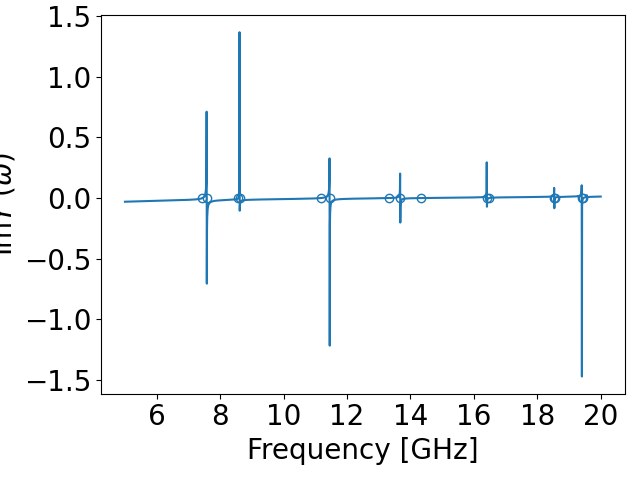

In [122]:
# Plot the results, save the figure(s)
fsize = 20
fig, ax = plt.subplots(1, 1, tight_layout=True)
ax.plot(f/fscale, y.imag,color='tab:blue')
ax.plot(wp/(2*np.pi*fscale), yp.imag, 'o', fillstyle='none',
        color='tab:blue', label='Zero Crossings')
ax.set_ylabel(r"Im$Y'(\omega)$", fontsize=fsize)
ax.set_xlabel(r'Frequency [GHz]', fontsize=fsize)
set_axes_fonts(ax, fsize)
fig.savefig(f'../figs/zeros_term_bbq_inductive_50um_{dstr}.pdf', format='pdf')

## Iterate over all LJ values

In [123]:
NLJ = 25
wps = []
ps = []
pcs = []
gDs = []
Cps = []
Lps = []
chis = []
Nmodes = 6

# Whether or not to use the largest impedance mode
# as the junction mode in the calculations
use_Zq = True

# LJs = np.linspace(10e-9, 100e-9, NLJ)
LJs = np.logspace(np.log10(0.1e-9), np.log10(10e-9), NLJ)
for idx, LJ in enumerate(LJs):
    wpp, Lp, Cp, _, _, _, p, pc, gD, chip \
    = get_wp_Cp_Lp(fdata, ydata, LJ0=LJ, fscale=fscale, use_Zq=use_Zq)
    # wps.append(wpp[0:4])
    sort_idx = np.argsort(wpp[0:Nmodes])
    # print(f'wpp: {wpp[0:Nmodes]/(2*np.pi*1e9)}')
    # print(f'wpp[sorted]: {wpp[sort_idx]/(2*np.pi*1e9)}')
    wps.append(wpp[0:Nmodes])
    ps.append(p[0:Nmodes])
    pcs.append(pc[0:Nmodes])
    gDs.append(gD[0:Nmodes])
    Lps.append(Lp[0:Nmodes])
    Cps.append(Cp[0:Nmodes])
    chis.append(chip[0:Nmodes, 0:Nmodes])
    # wps.append(wpp)
    # print(f'LJ: {LJ}, wpp: {wpp}')
wps = np.asarray(wps).T
ps  = np.asarray(ps).T
pcs  = np.asarray(pcs).T
gDs = np.asarray(gDs).T
Lps = np.asarray(Lps).T
Cps = np.asarray(Cps).T
chis = np.asarray(chis).T

In [124]:
wp0, _, _, _, _, _, _, _, _, _ = get_wp_Cp_Lp(fdata, ydata, fscale=fscale, LJ0=1e-9)

In [125]:
wp0

array([4.67311907e+10, 4.75951287e+10, 5.38783140e+10, 5.41139335e+10,
       7.02145958e+10, 7.19424718e+10, 8.36449044e+10, 8.59225591e+10,
       9.01244392e+10, 1.03083509e+11, 1.03515478e+11, 1.16435278e+11,
       1.16592357e+11, 1.21893795e+11, 1.22207954e+11])

<IPython.core.display.Javascript object>


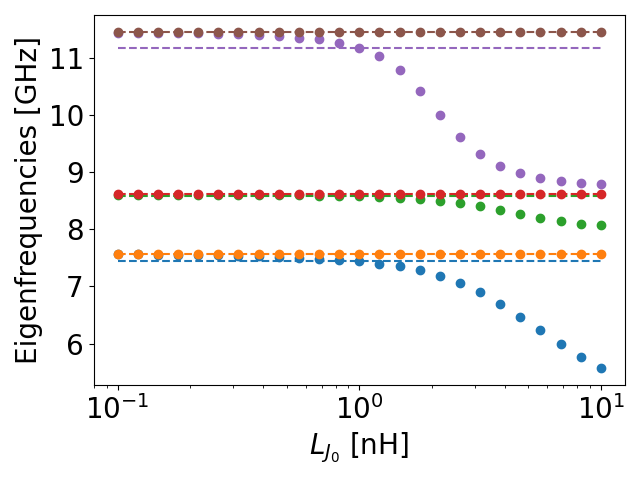

In [126]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
for idx, wppp in enumerate(wps):
    ax.plot(LJs/1e-9, wppp/(2*np.pi*fscale),
            'o', label=r'Mode-%d' % (idx + 1),
            color=cycle[idx%clen])
    ax.plot(LJs/1e-9, [wp0[idx]/(2*np.pi*fscale)] * len(LJs),
            '--', color=cycle[idx%clen])
ax.set_xlabel(r'$L_{J_0}$ [nH]', fontsize=fsize)
ax.set_ylabel(r'Eigenfrequencies [GHz]', fontsize=fsize)
set_axes_fonts(ax, fsize)
ax.set_xscale('log')
fig.savefig(f'../figs/modes_term_bbq_inductive_50um_{dstr}.pdf', format='pdf')

## Blackbox participation extraction

<IPython.core.display.Javascript object>


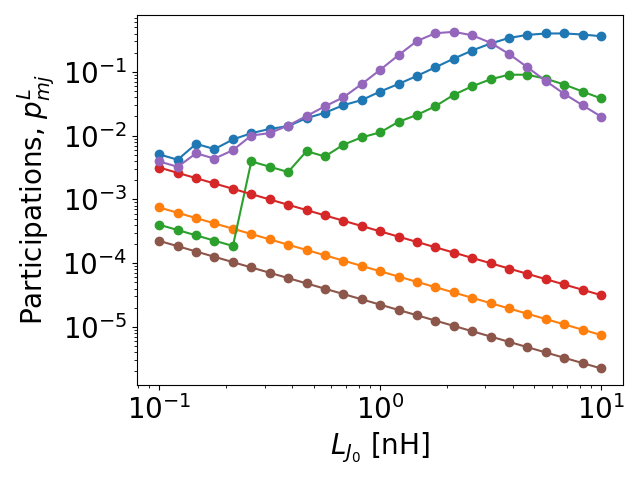

In [128]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
for idx, pp in enumerate(ps):
    ax.plot(LJs/1e-9, pp,
            'o-', label=r'Mode-%d' % (idx + 1),
            color=cycle[idx%clen])
ax.set_xlabel(r'$L_{J_0}$ [nH]', fontsize=fsize)
ax.set_ylabel(r'Participations, $p^L_{mj}$', fontsize=fsize)
set_axes_fonts(ax, fsize)
ax.set_xscale('log')
ax.set_yscale('log')
fig.savefig(f'../figs/pL_zoffset_jj_{dstr}.pdf',
            format='pdf')

<IPython.core.display.Javascript object>


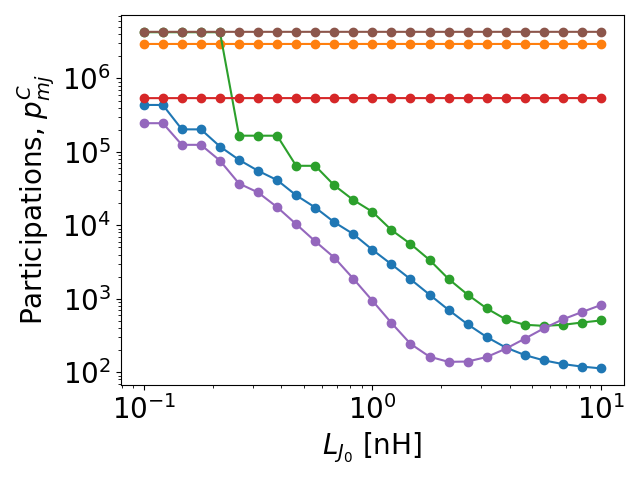

In [130]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
for idx, pp in enumerate(pcs):
    ax.plot(LJs/1e-9, pp,
            'o-', label=r'Mode-%d' % (idx + 1),
            color=cycle[idx%clen])
ax.set_xlabel(r'$L_{J_0}$ [nH]', fontsize=fsize)
ax.set_ylabel(r'Participations, $p^C_{mj}$', fontsize=fsize)
set_axes_fonts(ax, fsize)
ax.set_xscale('log')
ax.set_yscale('log')
fig.savefig(f'../figs/pC_zoffset_jj_{dstr}.pdf',format='pdf')

## $\frac{g}{\Delta}$ From Blackbox

<IPython.core.display.Javascript object>


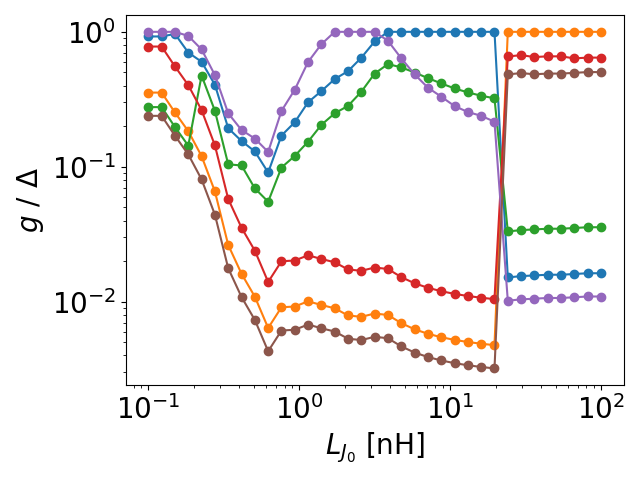

In [100]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
for idx, gg in enumerate(gDs):
    ax.plot(LJs/1e-9, gg,
            'o-', label=r'Mode-%d' % (idx + 1),
            color=cycle[idx%clen])
ax.set_xlabel(r'$L_{J_0}$ [nH]', fontsize=fsize)
ax.set_ylabel(r'$g\ /\ \Delta$', fontsize=fsize)
set_axes_fonts(ax, fsize)
ax.set_xscale('log')
ax.set_yscale('log')
fig.savefig(f'../figs/g_over_D_term_bbq_inductive_50um_{dstr}.pdf',
            format='pdf')

## $\chi$ from Black box

<IPython.core.display.Javascript object>


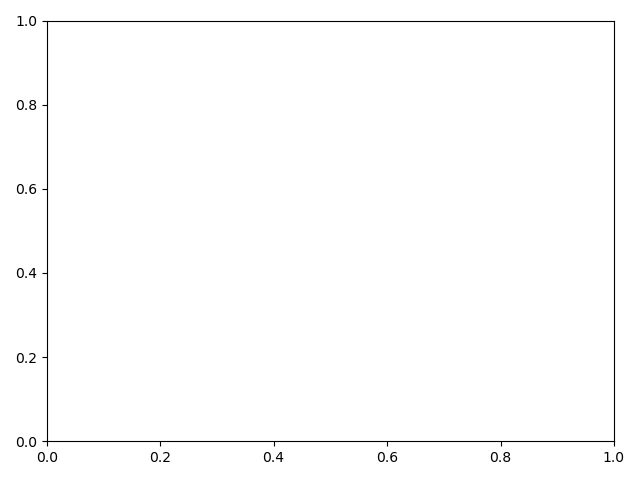

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [101]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
chi_scale = 1e6
chi_dict = {1e6: 'MHz', 1e9 : 'GHz'}
chi_str = chi_dict[chi_scale]
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
M1, M2 = [Nmodes, Nmodes]
for idx1 in range(M1):
    for idx2 in range(M2):
        if idx1 != idx2:
            ax.plot(LJs/1e-9, np.abs(chis[idx1, idx2, :])/chi_scale,
            'o-', label=r'$|\chi_{%d, %d}|$' % (idx1, idx2),
            color=cycle[(idx1*Nmodes+idx2)%clen])
ax.set_xlabel(r'$L_{J_0}$ [nH]', fontsize=fsize)
ax.set_ylabel(r'$|\chi_{i, j}|$ [%s]' % (chi_str),
              fontsize=fsize)
set_axes_fonts(ax, fsize)
ax.set_xscale('log')
ax.set_yscale('log')
fig.savefig(f'../figs/chis_bbq_inductive_50um_{dstr}.pdf',
           format='pdf')

## $\alpha$ from Black box

<IPython.core.display.Javascript object>


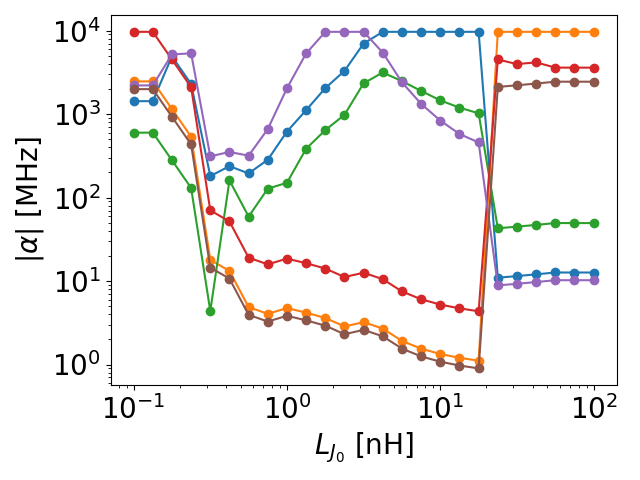

In [33]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
chi_scale = 1e6
chi_dict = {1e6: 'MHz', 1e9 : 'GHz'}
chi_str = chi_dict[chi_scale]
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
M1, M2 = [Nmodes, Nmodes]
for idx1 in range(M1):
        ax.plot(LJs/1e-9, 
                0.5 * np.abs(chis[idx1, idx1, :])/chi_scale,
                'o-', label=r'$|\alpha_{%d}|$' % (idx1),
                color=cycle[idx1%clen])
ax.set_xlabel(r'$L_{J_0}$ [nH]', fontsize=fsize)
ax.set_ylabel(r'$|\alpha|$ [%s]' % (chi_str),
              fontsize=fsize)
set_axes_fonts(ax, fsize)
ax.set_xscale('log')
ax.set_yscale('log')
fig.savefig(f'../figs/alpha_bbq_inductive_50um_{dstr}.pdf',
           format='pdf')

## Mode Capacitances, Inductances

<IPython.core.display.Javascript object>


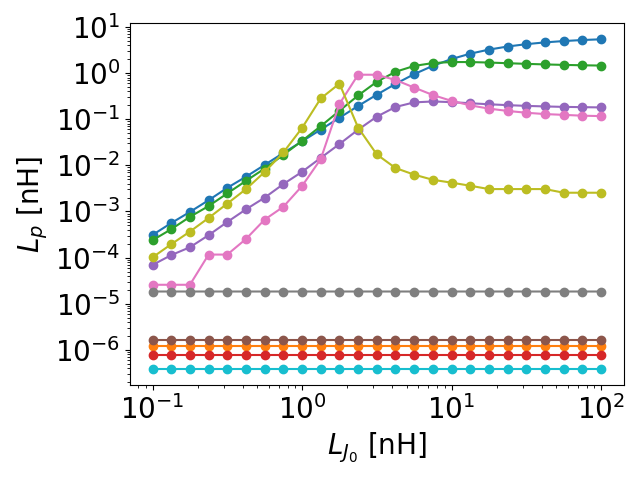

In [60]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
for idx, Lppp in enumerate(Lps):
    ax.plot(LJs/1e-9, Lppp / 1e-9,
            'o-',color=cycle[idx%clen])
ax.set_xlabel(r'$L_{J_0}$ [nH]', fontsize=fsize)
ax.set_ylabel(r'$L_p$ [nH]', fontsize=fsize)
set_axes_fonts(ax, fsize)
ax.set_xscale('log')
ax.set_yscale('log')
fig.savefig(f'../figs/Lp_term_bbq_inductive_50um_{dstr}.pdf',
            format='pdf')

<IPython.core.display.Javascript object>


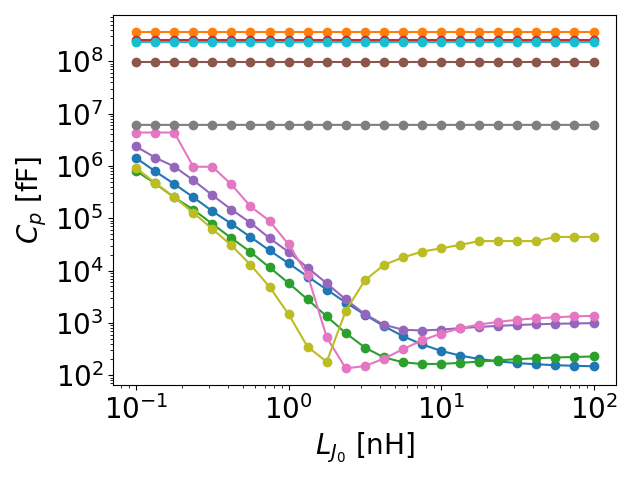

In [61]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
for idx, Cppp in enumerate(Cps):
    ax.plot(LJs/1e-9, Cppp / 1e-15,
            'o-',color=cycle[idx%clen])
ax.set_xlabel(r'$L_{J_0}$ [nH]', fontsize=fsize)
ax.set_ylabel(r'$C_p$ [fF]', fontsize=fsize)
set_axes_fonts(ax, fsize)
ax.set_xscale('log')
ax.set_yscale('log')
fig.savefig(f'../figs/Cp_term_bbq_inductive_50um_{dstr}.pdf',
            format='pdf')

## Mode Impedances

<IPython.core.display.Javascript object>


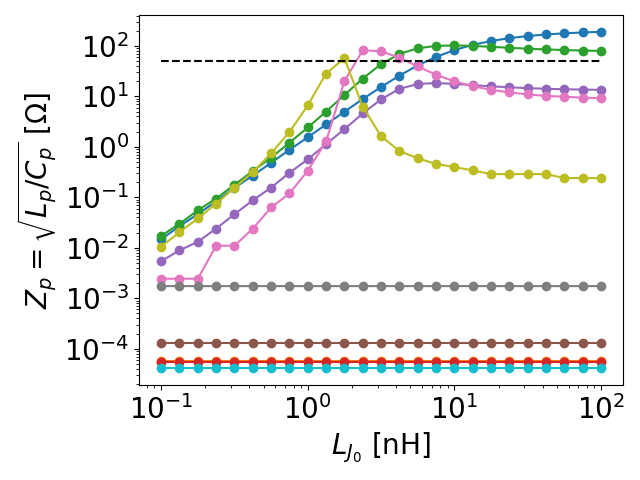

In [62]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
for idx, Cppp in enumerate(Cps):
    ax.plot(LJs/1e-9, np.sqrt(Lps[idx] / Cppp),
            'o-',color=cycle[idx%clen])
ax.plot(LJs / 1e-9, [50.] * len(LJs), 'k--')
ax.set_xlabel(r'$L_{J_0}$ [nH]', fontsize=fsize)
ax.set_ylabel(r'$Z_p=\sqrt{L_p/C_p}$ [$\Omega$]', fontsize=fsize)
set_axes_fonts(ax, fsize)
ax.set_xscale('log')
ax.set_yscale('log')
fig.savefig(f'../figs/Zp_term_bbq_inductive_50um_{dstr}.pdf',
            format='pdf')